In [ ]:
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers

import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import layers, models, regularizers
import numpy as np

import scipy.io
import os
import shutil
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

g = globals()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/NN final project')

## **Call Data**

In [ ]:
train_dataset = image_dataset_from_directory("./aerial_splits/train",
  image_size=(300, 300),
  batch_size=64, shuffle = True)

validation_dataset = image_dataset_from_directory("./aerial_splits/validate",
  image_size=(300, 300),
  batch_size=64, shuffle = True)

test_dataset = image_dataset_from_directory("./aerial_splits/test",
  image_size=(300, 300),
  batch_size=64)

Found 4494 files belonging to 3 classes.
Found 606 files belonging to 3 classes.
Found 604 files belonging to 3 classes.


#### **call test data, preserve image path order for evaluation**

In [ ]:
directory = './aerial_splits/test'
class_names = os.listdir(directory)
class_names.sort()  # Sort alphabetically, this needs to match 'image_dataset_from_directory'


file_paths = []
labels = []


for label, class_name in enumerate(class_names):
    class_dir = os.path.join(directory, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith('.png'):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(label)

# Ensure paths are sorted to maintain alignment with labels
file_paths = sorted(file_paths)

def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [300, 300])  # Resize to model input shape
    return img, label

test_dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
test_dataset = test_dataset.map(process_image)  # Apply  processing
test_dataset = test_dataset.batch(64)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### **Custom Convolutional Nets**

#### **Model 1**



In [ ]:
#5 convolution layers each followed by pooling
#filters start at 32 and double upto 256.
# kernel size = 1
# 3 neurons in final dense layer, with softmax activation

inputs = keras.Input(shape=(300, 300, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)


#### **Model 2**



In [ ]:
#9 convolution layers. Pooling after two convolution layers
#filters start at 32 and double upto 512.
# kernel size = 3
# 3 neurons in final dense layer, with softmax activation

inputs2 = keras.Input(shape=(300, 300, 3))
x2 = layers.Rescaling(1./255)(inputs2)
x2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x2)
x2 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x2)
x2 = layers.MaxPooling2D(pool_size=2)(x2)
x2 = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x2)
x2 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x2)
x2 = layers.MaxPooling2D(pool_size=2)(x2)
x2 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x2)
x2 = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x2)
x2 = layers.MaxPooling2D(pool_size=2)(x2)
x2 = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x2)
x2 = layers.Flatten()(x2)
outputs2 = layers.Dense(3, activation="softmax")(x2)
model2 = keras.Model(inputs=inputs2, outputs=outputs2)

In [ ]:
model.summary()
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      128       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      2112      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 64)        0         
 g2D)                                                        

#### **Compiling and training**

In [ ]:
## loss is sparse categorical due to multi class problem. image_dataset_from directory creates ordinal labels for each class
# like 1,2,3,4. sparse categorical to treat these labels as categorical. alternative to one hot encoding
optimizer1 = keras.optimizers.Adam(learning_rate=0.001)
optimizer2 = keras.optimizers.Adam(learning_rate=0.001)


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer1,
              metrics=["accuracy"])

model2.compile(loss="sparse_categorical_crossentropy",
               optimizer=optimizer2,
               metrics=["accuracy"])


In [ ]:
histories = {}

In [ ]:
for i in ['model', 'model2']:
    if i == 'model':
        fpath = 'CNN_unstacked_aerial_classification'
    else:
        fpath = 'CNN_stacked_aerial_classification'

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=fpath,
            save_best_only=True,
            monitor="val_loss"),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True,
            mode='max',
            verbose=1)
    ]

    histories['history_{}'.format(i)] = g[i].fit(
        train_dataset,
        epochs=30,
        validation_data=validation_dataset,
        callbacks=callbacks)


Epoch 1/30
71/71 [==============================] - 20s 180ms/step - loss: 0.9817 - accuracy: 0.5636 - val_loss: 1.1016 - val_accuracy: 0.4125
Epoch 2/30
71/71 [==============================] - 12s 156ms/step - loss: 0.9006 - accuracy: 0.6206 - val_loss: 0.9253 - val_accuracy: 0.6089
Epoch 3/30
71/71 [==============================] - 12s 155ms/step - loss: 0.8492 - accuracy: 0.6493 - val_loss: 0.8628 - val_accuracy: 0.6337
Epoch 4/30
71/71 [==============================] - 12s 159ms/step - loss: 0.8349 - accuracy: 0.6573 - val_loss: 0.8530 - val_accuracy: 0.6386
Epoch 5/30
71/71 [==============================] - 12s 155ms/step - loss: 0.8286 - accuracy: 0.6544 - val_loss: 0.7890 - val_accuracy: 0.6601
Epoch 6/30
71/71 [==============================] - 11s 140ms/step - loss: 0.7990 - accuracy: 0.6640 - val_loss: 0.8311 - val_accuracy: 0.6584
Epoch 7/30
71/71 [==============================] - 12s 155ms/step - loss: 0.7824 - accuracy: 0.6729 - val_loss: 0.7680 - val_accuracy: 0.6667

#### **Evaluation**

Text(0.5, 1.0, 'Training and Validation Accuracy (history_model)')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss (history_model)')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy (history_model2)')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss (history_model2)')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

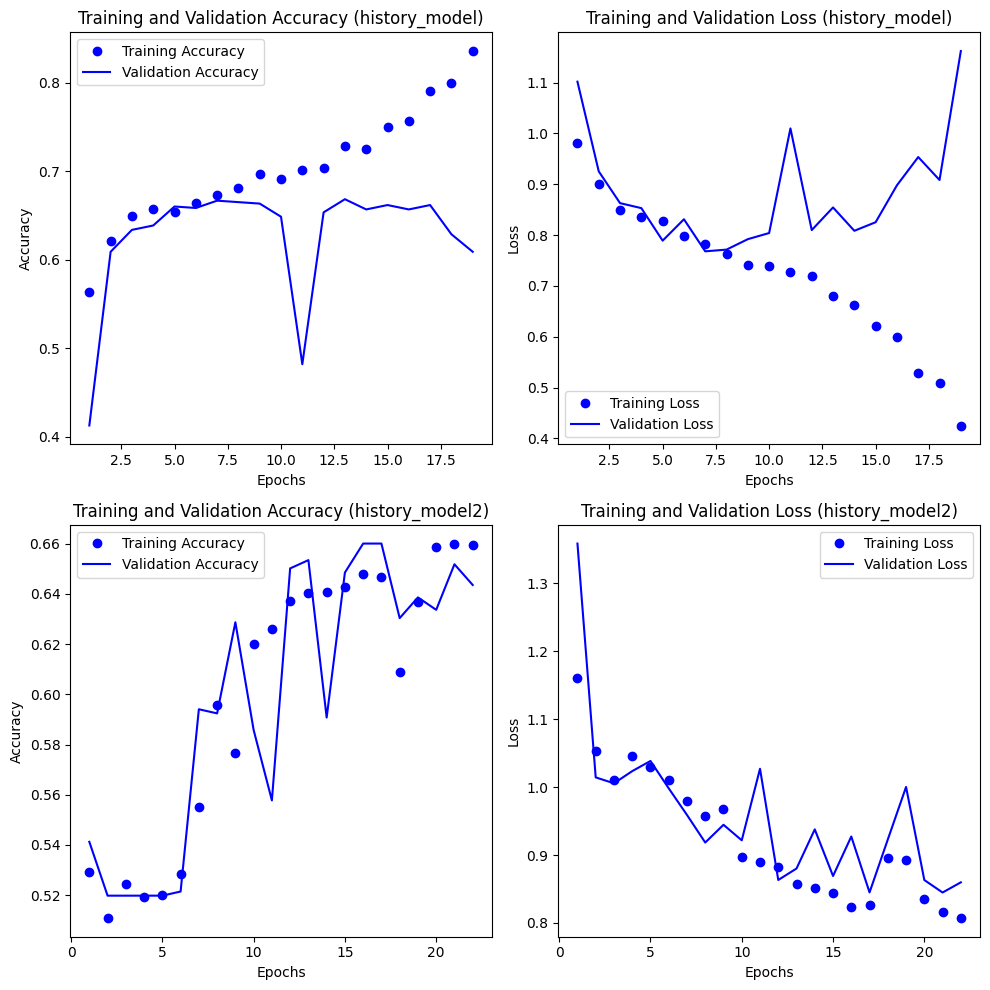

In [ ]:
num_histories = len(histories)

fig, axes = plt.subplots(nrows=num_histories, ncols=2, figsize=(10, 10))


for i, (history_key, history) in enumerate(histories.items()):

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)


    axes[i, 0].plot(epochs, accuracy, "bo", label="Training Accuracy")
    axes[i, 0].plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    axes[i, 0].set_title(f"Training and Validation Accuracy ({history_key})")
    axes[i, 0].set_xlabel("Epochs")
    axes[i, 0].set_ylabel("Accuracy")
    axes[i, 0].legend()


    axes[i, 1].plot(epochs, loss, "bo", label="Training Loss")
    axes[i, 1].plot(epochs, val_loss, "b", label="Validation Loss")
    axes[i, 1].set_title(f"Training and Validation Loss ({history_key})")
    axes[i, 1].set_xlabel("Epochs")
    axes[i, 1].set_ylabel("Loss")
    axes[i, 1].legend()


plt.tight_layout()
plt.show()

In [ ]:
import json
histories_to_save = {}
for key, history in histories.items():
    histories_to_save[key] = {
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }

filename = 'training_histories_aerial_classification_customcnn.json'


with open(filename, 'w') as f:
    json.dump(histories_to_save, f, indent=4)

### **Test Performance**

In [ ]:
test_model_unstacked = keras.models.load_model("./CNN_unstacked_aerial_classification")
test_loss, test_acc = test_model_unstacked.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

test_model_stacked = keras.models.load_model("./CNN_stacked_aerial_classification")
test_loss, test_acc = test_model_stacked.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


10/10 [==============================] - 45s 4s/step - loss: 0.7806 - accuracy: 0.6705
Test accuracy: 0.671
10/10 [==============================] - 8s 802ms/step - loss: 0.8269 - accuracy: 0.6672
Test accuracy: 0.667


In [ ]:
class_names = train_dataset.class_names
print("Class names:", class_names)

Class names: ['label_between 0 and 1.5', 'label_less than 0', 'label_more than 1.5']


In [ ]:
predicted_labels = []
true_labels = []

## unstacked model
for images, batch_labels in test_dataset:
    preds = test_model_unstacked.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    predicted_labels.extend(predicted_classes)
    true_labels.extend(batch_labels.numpy())

results_df_unstacked = pd.DataFrame({
    'File Path': file_paths,
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})

predicted_labels = []
true_labels = []

##stacked model
for images, batch_labels in test_dataset:
    preds = test_model_stacked.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    predicted_labels.extend(predicted_classes)
    true_labels.extend(batch_labels.numpy())

results_df_stacked = pd.DataFrame({
    'File Path': file_paths,
    'True Label': true_labels,
    'Predicted Label': predicted_labels})

1/1 [==============================] - 0s 123ms/step


In [ ]:
confusion_unstacked = results_df_unstacked.groupby('True Label')['Predicted Label'].value_counts().unstack(fill_value=0)

print('Unstacked Model Results Distribution')
confusion_unstacked

confusion_stacked = results_df_stacked.groupby('True Label')['Predicted Label'].value_counts().unstack(fill_value=0)

print('Stacked Model Results Distribution')
confusion_stacked

Unstacked Model Results Distribution


Predicted Label,0,1,2
True Label,,,
0,9,26,102
1,6,103,45
2,4,16,293


Stacked Model Results Distribution


Predicted Label,0,1,2
True Label,,,
0,6,34,97
1,1,116,37
2,0,32,281


## **Model 2 with augmentation - flips, rotation and zoom**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### **Augmentation results**

<Figure size 2000x2000 with 0 Axes>

(-0.5, 299.5, 299.5, -0.5)

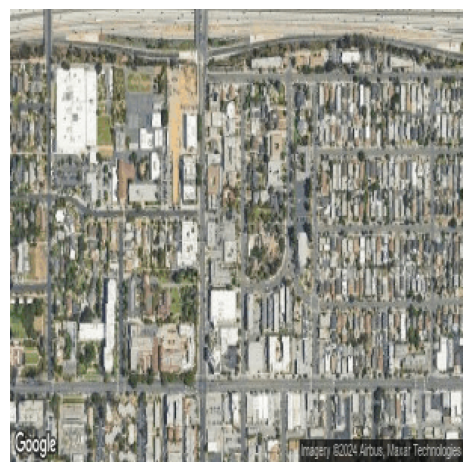

In [ ]:
plt.figure(figsize=(20, 20))
for images, _ in train_dataset.take(1):
    # for i in range(9):
        # augmented_images = data_augmentation(images)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[5].numpy().astype("uint8"))
      plt.axis("off")

### **Compiling and Training**

In [ ]:
inputs = keras.Input(shape=(300, 300, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation="softmax")(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 149, 149, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 73, 73, 64)        0         
 ng2D)                                                     

In [ ]:
optimizer3 = keras.optimizers.Adam(learning_rate=0.001)


model3.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer3,
              metrics=["accuracy"])

In [ ]:
history_augmented_2 = {}
fpath = "CNN_unstacked_augment_aerial_classification.keras"
callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=fpath,
            save_best_only=True,
            monitor="val_loss"),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True,
            mode='max',
            verbose=1)  ]


history_augmented_2['history_augmented_2'] = model3.fit(
      train_dataset,
      epochs=30,
      validation_data=validation_dataset,
      callbacks = callbacks)

Epoch 1/30
71/71 [==============================] - 19s 169ms/step - loss: 1.0382 - accuracy: 0.5162 - val_loss: 1.0021 - val_accuracy: 0.6386
Epoch 2/30
71/71 [==============================] - 11s 138ms/step - loss: 0.9964 - accuracy: 0.5625 - val_loss: 0.8806 - val_accuracy: 0.6287
Epoch 3/30
71/71 [==============================] - 11s 138ms/step - loss: 0.8707 - accuracy: 0.6371 - val_loss: 0.8695 - val_accuracy: 0.6304
Epoch 4/30
71/71 [==============================] - 11s 138ms/step - loss: 0.8813 - accuracy: 0.6326 - val_loss: 0.8424 - val_accuracy: 0.6568
Epoch 5/30
71/71 [==============================] - 10s 136ms/step - loss: 0.8399 - accuracy: 0.6511 - val_loss: 0.8519 - val_accuracy: 0.6535
Epoch 6/30
71/71 [==============================] - 11s 138ms/step - loss: 0.8338 - accuracy: 0.6502 - val_loss: 0.8241 - val_accuracy: 0.6601
Epoch 7/30
71/71 [==============================] - 11s 138ms/step - loss: 0.8240 - accuracy: 0.6591 - val_loss: 0.8176 - val_accuracy: 0.6568

### **Evaluation**

<Figure size 1200x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Training and Validation Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

<Axes: >

Text(0.5, 1.0, 'Training and Validation Accuracy')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Accuracy')

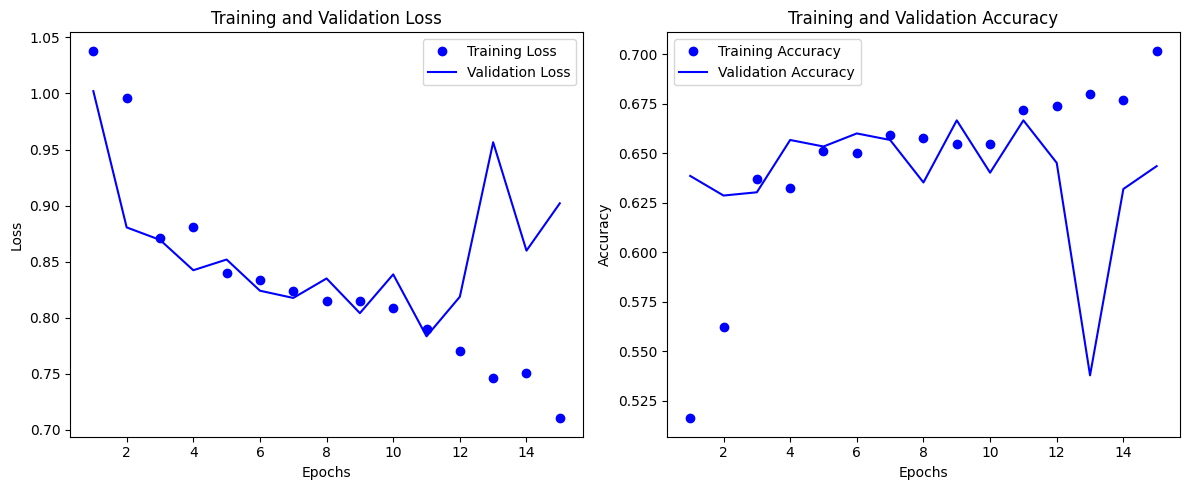

In [ ]:
history_dict = history_augmented_2['history_augmented_2'].history  # Access the .history attribute to get the dictionary of histories.

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Check if accuracy metrics are available and plot them
if 'accuracy' in history_dict:
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

### **Test Performance**

In [ ]:
test_model_aug = keras.models.load_model("CNN_unstacked_augment_aerial_classification.keras")
test_loss, test_acc = test_model_aug.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

10/10 [==============================] - 2s 165ms/step - loss: 0.7662 - accuracy: 0.6722
Test accuracy: 0.672


In [ ]:
predicted_labels = []
true_labels = []

## stacked and augmentation model
for images, batch_labels in test_dataset:
    preds = test_model_aug.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    predicted_labels.extend(predicted_classes)
    true_labels.extend(batch_labels.numpy())

results_df_stack_aug = pd.DataFrame({
    'File Path': file_paths,
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})

confusion_stacked_aug = results_df_stack_aug.groupby('True Label')['Predicted Label'].value_counts().unstack(fill_value=0)

print('Stacked Model with Augmentation Results Distribution')
confusion_stacked_aug

1/1 [==============================] - 0s 101ms/step
Stacked Model with Augmentation Results Distribution


Predicted Label,0,1,2
True Label,,,
0,9,31,97
1,5,112,37
2,5,23,285


In [ ]:
import json

histories_to_save = {}

# Assuming history_augmented_2 is a dictionary of Keras History objects
for key, history in history_augmented_2.items():
    histories_to_save[key] = {
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss']
    }

filename = 'training_histories_augment_aerial_classification.json'

# Write the dictionary to a file as JSON
with open(filename, 'w') as f:
    json.dump(histories_to_save, f, indent=4)

## **VGG16**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(300, 300, 3))
conv_base.trainable = False

### **Defining Model**

In [ ]:
## Adding a fully connected dense layer

inputs5 = keras.Input(shape=(300, 300, 3))
x5 = data_augmentation(inputs5)
x5 = keras.applications.vgg16.preprocess_input(x5)
x5 = conv_base(x5)
x5 = layers.Flatten()(x5)
x5 = layers.Dense(256)(x5)
outputs5 = layers.Dense(3, activation="softmax")(x5)
model_vgg = keras.Model(inputs=inputs5, outputs=outputs5)

In [ ]:
model_vgg.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 tf.__operators__.getitem_1  (None, 300, 300, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 300, 300, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 41472)             0   

## **Fitting VGG16**




In [ ]:
optimizer4 = keras.optimizers.Adam(learning_rate=0.001)
model_vgg.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer4,
              metrics=["accuracy"])

In [ ]:
callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath="VGG16_aerial_classification_aug.h5",
            save_best_only=True,
            monitor="val_loss"),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True,
            mode='max',
            verbose=1)  ]

history_vgg = model_vgg.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks = callbacks)


Epoch 1/30
71/71 [==============================] - ETA: 0s - loss: 44.3886 - accuracy: 0.5607

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


71/71 [==============================] - 57s 566ms/step - loss: 44.3886 - accuracy: 0.5607 - val_loss: 25.6019 - val_accuracy: 0.6469
Epoch 2/30
71/71 [==============================] - 33s 455ms/step - loss: 11.3106 - accuracy: 0.6199 - val_loss: 6.5080 - val_accuracy: 0.6254
Epoch 3/30
71/71 [==============================] - 34s 458ms/step - loss: 2.2052 - accuracy: 0.6257 - val_loss: 1.3603 - val_accuracy: 0.6370
Epoch 4/30
71/71 [==============================] - 34s 464ms/step - loss: 0.8711 - accuracy: 0.6720 - val_loss: 0.9235 - val_accuracy: 0.6865
Epoch 5/30
71/71 [==============================] - 32s 438ms/step - loss: 0.7172 - accuracy: 0.7023 - val_loss: 0.9628 - val_accuracy: 0.6749
Epoch 6/30
71/71 [==============================] - 32s 442ms/step - loss: 0.7127 - accuracy: 0.7081 - val_loss: 0.9669 - val_accuracy: 0.6700
Epoch 7/30
71/71 [==============================] - 34s 465ms/step - loss: 0.7203 - accuracy: 0.7103 - val_loss: 0.9019 - val_accuracy: 0.6716
Epoch 8

### **Test Performance**

In [ ]:
class_names = train_dataset.class_names
print("Class names:", class_names)
test_model_vgg = keras.models.load_model("VGG16_aerial_classification_aug.h5")
test_loss, test_acc = test_model_vgg.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

predicted_labels = []
true_labels = []

## VGG16
for images, batch_labels in test_dataset:
    preds = test_model_vgg.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    predicted_labels.extend(predicted_classes)
    true_labels.extend(batch_labels.numpy())

results_df_vgg = pd.DataFrame({
    'File Path': file_paths,
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})

confusion_vgg = results_df_vgg.groupby('True Label')['Predicted Label'].value_counts().unstack(fill_value=0)

print('VGG16 with Augmentation Results Distribution')
confusion_vgg

Class names: ['label_between 0 and 1.5', 'label_less than 0', 'label_more than 1.5']
10/10 [==============================] - 10s 1s/step - loss: 0.9103 - accuracy: 0.6623
Test accuracy: 0.662
1/1 [==============================] - 0s 163ms/step
VGG16 with Augmentation Results Distribution


Predicted Label,0,1,2
True Label,,,
0,30,39,68
1,19,117,18
2,28,32,253


### **Evaluation**

Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

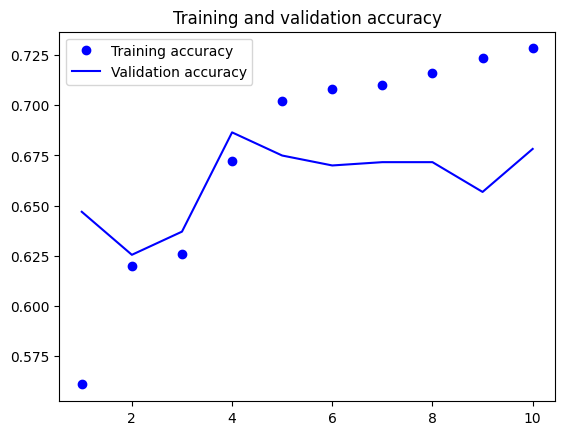

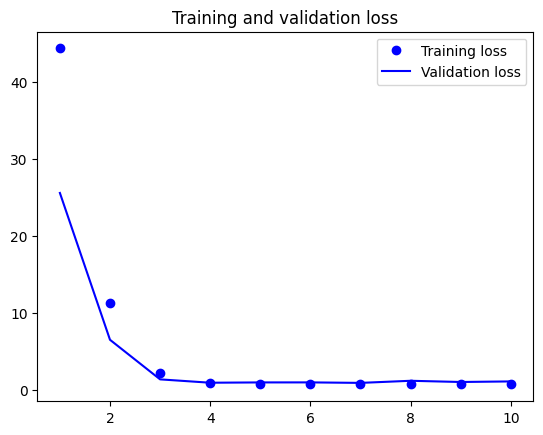

In [ ]:
import matplotlib.pyplot as plt
acc = history_vgg.history["accuracy"]
val_acc = history_vgg.history["val_accuracy"]
loss = history_vgg.history["loss"]
val_loss = history_vgg.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## **Inception V3**

### **Freeze weights and Define Model**

In [ ]:
#using L2 regularization

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
x6 = base_model.output
x6 = layers.Flatten()(x6)
x6 = layers.Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.04))(x6)
predictions = layers.Dense(3, activation="softmax",kernel_regularizer=regularizers.l2(0.03))(x6)
lenet = keras.Model(inputs=base_model.input, outputs=predictions)


### **Using Adaptive Learning rate**

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=71,
    decay_rate=0.96,
    staircase=True)

optimizer5 = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lenet.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer5,
              metrics=["accuracy"])

### **Compiling and Training**

In [ ]:
callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath="lenet_classify.h5",
            save_best_only=True,
            monitor="val_loss"),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=4,
            restore_best_weights=True,
            mode='max',
            verbose=1)  ]
history_lenet = lenet.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks = callbacks)

Epoch 1/30
71/71 [==============================] - 63s 498ms/step - loss: 27.7545 - accuracy: 0.6150 - val_loss: 15.4940 - val_accuracy: 0.6287
Epoch 2/30
71/71 [==============================] - 46s 611ms/step - loss: 10.4334 - accuracy: 0.7036 - val_loss: 6.9575 - val_accuracy: 0.6766
Epoch 3/30
71/71 [==============================] - 47s 620ms/step - loss: 4.9751 - accuracy: 0.7882 - val_loss: 3.8343 - val_accuracy: 0.7079
Epoch 4/30
71/71 [==============================] - 47s 618ms/step - loss: 2.6641 - accuracy: 0.8761 - val_loss: 2.5012 - val_accuracy: 0.7492
Epoch 5/30
71/71 [==============================] - 46s 606ms/step - loss: 1.5584 - accuracy: 0.9239 - val_loss: 1.7795 - val_accuracy: 0.7393
Epoch 6/30
71/71 [==============================] - 48s 624ms/step - loss: 0.9630 - accuracy: 0.9608 - val_loss: 1.5212 - val_accuracy: 0.7558
Epoch 7/30
71/71 [==============================] - 47s 625ms/step - loss: 0.6422 - accuracy: 0.9717 - val_loss: 1.3587 - val_accuracy: 0.7

### **Evaluation**

Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

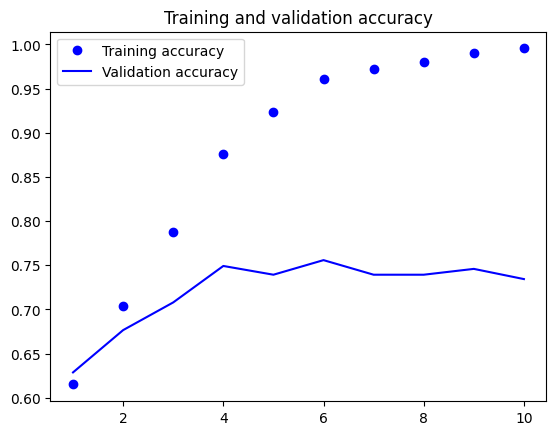

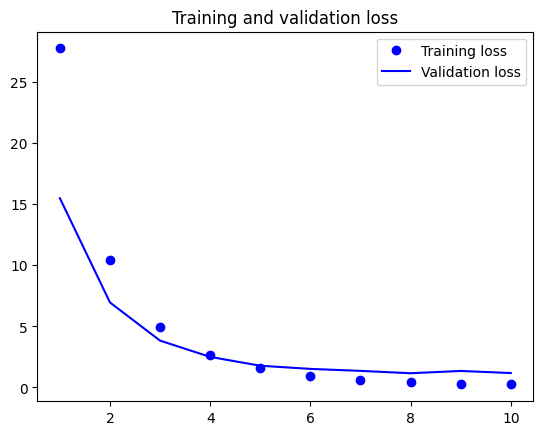

In [ ]:
import matplotlib.pyplot as plt
acc = history_lenet.history["accuracy"]
val_acc = history_lenet.history["val_accuracy"]
loss = history_lenet.history["loss"]
val_loss = history_lenet.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### **Test Performance**

In [ ]:
class_names = train_dataset.class_names
print("Class names:", class_names)
test_model_lenet = keras.models.load_model("lenet_classify.h5")
test_loss, test_acc = test_model_lenet.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Class names: ['label_between 0 and 1.5', 'label_less than 0', 'label_more than 1.5']
10/10 [==============================] - 25s 2s/step - loss: 1.4038 - accuracy: 0.7003
Test accuracy: 0.700


In [ ]:
predicted_labels = []
true_labels = []
test_model_lenet = keras.models.load_model("lenet_classify.h5")
for images, batch_labels in test_dataset:
    preds = test_model_lenet.predict(images)
    predicted_classes = np.argmax(preds, axis=1)
    predicted_labels.extend(predicted_classes)
    true_labels.extend(batch_labels.numpy())

results_df_lenet = pd.DataFrame({
    'File Path': file_paths,
    'True Label': true_labels,
    'Predicted Label': predicted_labels
})

confusion_lenet= results_df_lenet.groupby('True Label')['Predicted Label'].value_counts().unstack(fill_value=0)
print('Lenet with Augmentation Results Distribution')
confusion_lenet

1/1 [==============================] - 4s 4s/step
Lenet with Augmentation Results Distribution


Predicted Label,0,1,2
True Label,,,
0,50,36,51
1,16,118,20
2,30,28,255


##**Save and compile prediction dataframes**

In [ ]:
results = []
for var_name in globals():
    if var_name.startswith('results_df'):
        results.append(var_name)

folder_name = 'model_results_aerial'

os.makedirs(folder_name, exist_ok=True)
for i in results:
  g[i].to_csv(f'{folder_name}/{i}.csv', index=False)

## **Investigating Feature Maps**

In [ ]:
model = keras.models.load_model("lenet_classify.h5")

In [ ]:
#true 0 predicted 2: ./aerial_splits/test/label_between 0 and 1.5/0012144.png
#true 0 predicted 1: ./aerial_splits/test/label_between 0 and 1.5/0012572.png
#true 0 predicted 0:	./aerial_splits/test/label_between 0 and 1.5/001035.png
#true 0 predicted 0: 	./aerial_splits/test/label_between 0 and 1.5/0012883.png

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:300]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
img_path = './aerial_splits/test/label_between 0 and 1.5/0012883.png'
img = image.load_img(img_path, target_size=(300, 300))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

In [ ]:
activations = activation_model.predict(img_array)

1/1 [==============================] - 0s 34ms/step


<Figure size 1300x400 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Original Block')

(-0.5, 299.5, 299.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Channel 4')

(-0.5, 148.5, 148.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Channel 5')

(-0.5, 148.5, 148.5, -0.5)

<Axes: >

Text(0.5, 1.0, 'Channel 3')

(-0.5, 148.5, 148.5, -0.5)

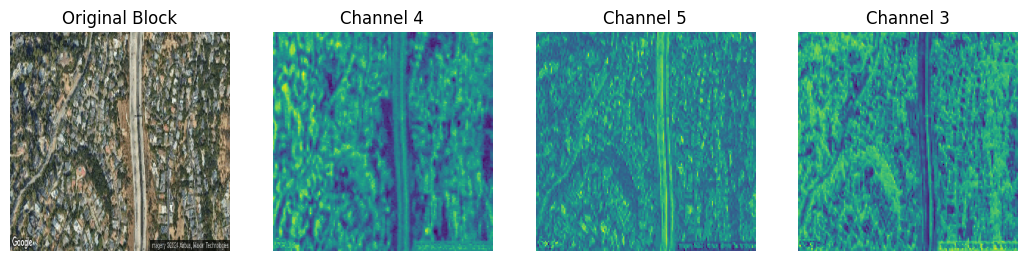

In [ ]:
import matplotlib.pyplot as plt

first_layer_activation = activations[3]

plt.figure(figsize=(13, 4))

# Plot  original image .
plt.subplot(1, 4, 1)  # 1 row, 4 columns, 1st plot.
plt.imshow(img)
plt.title('Original Block')
plt.axis('off')

#plot the feature maps.
subplot_index = 2  # second position for  feature maps.

for i in [4, 5, 3]:
    plt.subplot(1, 4, subplot_index)
    plt.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    plt.title(f'Channel {i}')
    plt.axis('off')
    subplot_index += 1

plt.show()